# Clustering and differential expression analysis using scanpy

In [40]:
import numpy as np
import pandas as pd
import scanpy as sc
import json
import os
import matplotlib.pyplot as plt
from scipy.stats import rankdata

In [41]:
dataset_name = 'PBMC1'
data_path = '../../dataset/{}-Filtered/10X/'.format(dataset_name)
default_path = '../../results/{}/scanpy/'.format(dataset_name)
celltypist_path = '../../results/{}/scanpy/celltypist/'.format(dataset_name)
protein_path = '../../results/{}/scanpy/protein/'.format(dataset_name)

nclusters_celltypist_path = '../../dataset/{}-Filtered/raw/nclusters.json'.format(dataset_name)
nclusters_protein_path = '../../dataset/{}-Filtered/10x/nclusters.json'.format(dataset_name)

with open(nclusters_celltypist_path) as f:
    nclusters_celltypist = json.load(f)['nclusters']
with open(nclusters_protein_path) as f:
    nclusters_protein = json.load(f)['nclusters']

if not os.path.exists(default_path):
    os.makedirs(default_path)

if not os.path.exists(celltypist_path):
    os.makedirs(celltypist_path)

if not os.path.exists(protein_path):
    os.makedirs(protein_path)

## Data loading and preparation

Dataset loading

In [42]:
adata = sc.read_10x_mtx(
    data_path,
    var_names='gene_symbols',
    cache=False
)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 3610 × 14366
    var: 'gene_ids'

Studying feature variance

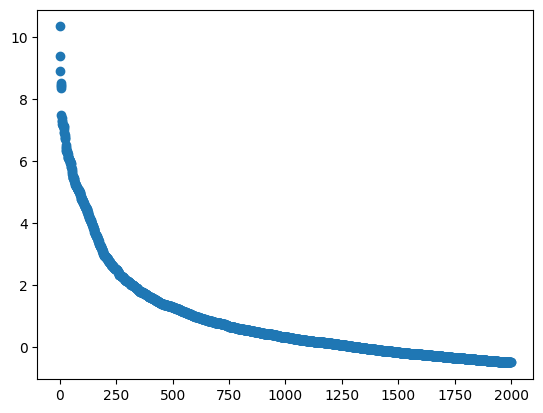

In [43]:
matrix = adata.X
matrix = matrix.todense()
neg_variances = np.sort(-np.var(matrix, axis=0))
sorted_log_variances = [np.log(-i) for i in neg_variances.T][:2000]
plt.scatter([i for i in range(len(sorted_log_variances))], sorted_log_variances)

Data normalization

In [44]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Feature selection

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


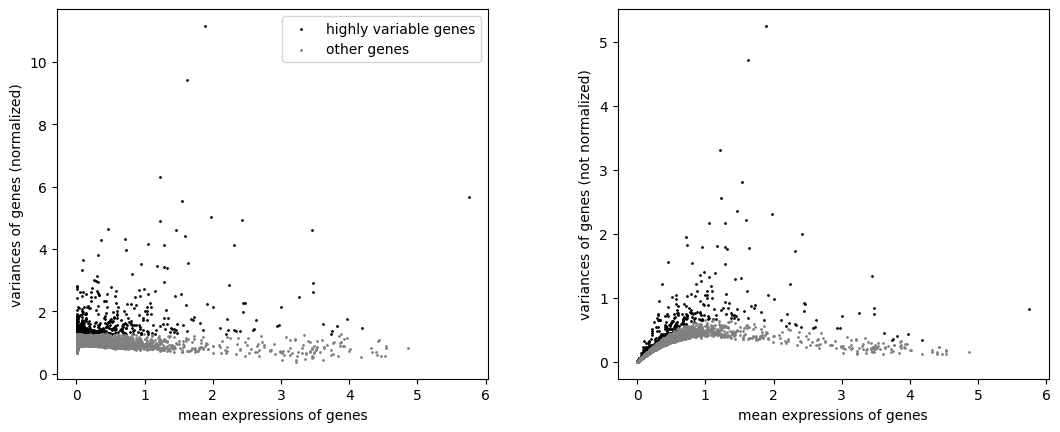

In [45]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=500, # chosen based on elbow plot above
    flavor='seurat_v3'
)
sc.pl.highly_variable_genes(adata)

Feature scaling

In [46]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10) # default=None, 10 in the tutorial on pbmc

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Clustering

Plot pca explained variance ratio to choose number of components

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


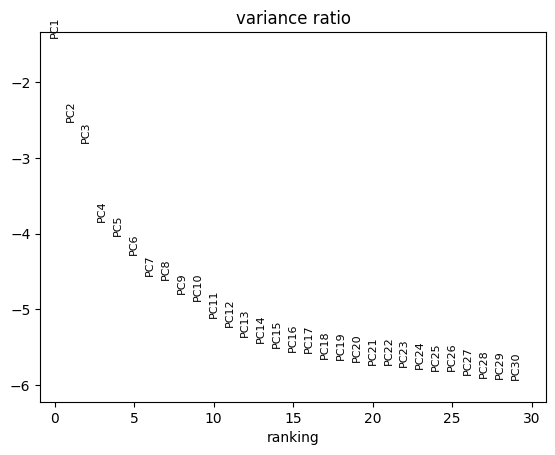

In [47]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=30, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

### Clustering with default parameters

Perform the clustering

In [49]:
sc.pp.neighbors(
    adata,
    n_pcs=10 # chosen based on elbow plot above
)
sc.tl.leiden(adata)

Visualize the clustering in the PCA space

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


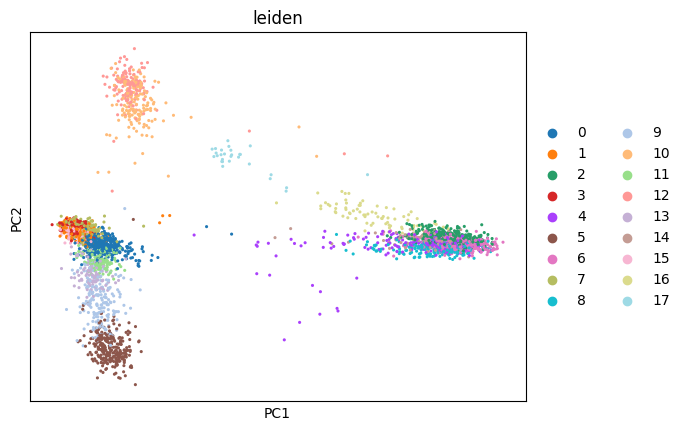

In [50]:
sc.pl.pca(
    adata,
    color=['leiden'],
    size=20
)

Save the clustering results

In [51]:
df = pd.DataFrame(adata.obs['leiden'])
labels = df.rename(columns={'leiden': 'cluster'})
labels.index.name = 'cell'
labels['cluster'] = labels['cluster'].astype(int) + 1
labels.to_csv(f'{default_path}/clustering_labels.csv', index=True)
num_clusters = len(labels['cluster'].unique())

## Differential expression on default clusters

In [52]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') # default='t-test', wilcoxon suggested in the tutorial

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Save markers

In [53]:
number_of_markers = 500
df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])
for i in range(num_clusters):
    indices = np.argsort(adata.uns['rank_genes_groups']['pvals_adj'][str(i)])
    genes = adata.uns['rank_genes_groups']['names'][str(i)][indices][:number_of_markers]
    ranks = rankdata(adata.uns['rank_genes_groups']['pvals_adj'][str(i)][indices][:number_of_markers], method="ordinal")
    df_to_add = pd.DataFrame(
        np.column_stack((genes, [i+1 for _ in range(number_of_markers)], ranks)),
        columns=['gene', 'cluster', 'rank']
    )
    df = pd.concat([df, df_to_add], ignore_index=True)

df['cluster'] = df['cluster'].astype(int)
df['rank'] = df['rank'].astype(int)
df.to_csv(f'{default_path}/markers.csv', index=False)

### Clustering tuning resolution according to celltypist

In [54]:
print("Nummber of clusters to find: {}".format(nclusters_celltypist))

Nummber of clusters to find: 13


In [55]:
# get ids of clusters bigger than 40 cells
mapping = pd.read_csv('../../dataset/{}-Filtered/raw/celltypist_mapping.csv'.format(dataset_name))
counts = pd.read_csv('../../dataset/{}-Filtered/raw/celltypist_annotation_counts.csv'.format(dataset_name))
mapping_counts = mapping.merge(counts, left_on='go', right_on='cluster.ids')
mapping_counts = mapping_counts[mapping_counts['count'] > 40]
clusters_ids_to_keep = mapping_counts['id']

# get barcodes of cells in clusters bigger than 40 cells
celltypist_labels = pd.read_csv('../../dataset/{}-Filtered/raw/celltypist_labels.csv'.format(dataset_name))
celltypist_labels = celltypist_labels[celltypist_labels['cluster.ids'].isin(clusters_ids_to_keep)]
barcodes_to_keep = celltypist_labels['cell']
subset_cells = adata.obs_names.isin(barcodes_to_keep)
adata_celltypist = adata[subset_cells, :]

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Perform the clustering

In [62]:
range_upper = 3
range_lower = 0

while True:
    resolution = (range_upper + range_lower)/2
    print("Trying resolution: {}".format(resolution))
    sc.tl.leiden(adata_celltypist, key_added="leiden_scVI", resolution=resolution)
    num_clusters = adata_celltypist.obs.leiden_scVI.values.categories.nunique()
    print("Number of clusters found: {}".format(num_clusters))

    if num_clusters == nclusters_celltypist:
        break
    elif num_clusters < nclusters_celltypist:
        range_lower = resolution
    else:
        range_upper = resolution

Trying resolution: 1.5
Number of clusters found: 24
Trying resolution: 0.75
Number of clusters found: 14
Trying resolution: 0.375
Number of clusters found: 9
Trying resolution: 0.5625
Number of clusters found: 14
Trying resolution: 0.46875
Number of clusters found: 12
Trying resolution: 0.515625
Number of clusters found: 12
Trying resolution: 0.5390625
Number of clusters found: 13


Visualize the clustering in the PCA space

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


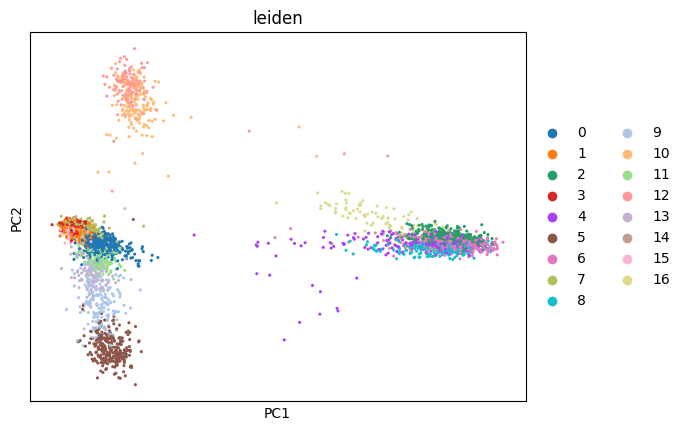

In [63]:
sc.pl.pca(
    adata_celltypist,
    color=['leiden'],
    size=20
)

Save the clustering results

In [64]:
df = pd.DataFrame(adata_celltypist.obs['leiden'])
labels = df.rename(columns={'leiden': 'cluster'})
labels.index.name = 'cell'
labels['cluster'] = labels['cluster'].astype(int) + 1
labels.to_csv(f'{celltypist_path}/clustering_labels.csv', index=True)
num_clusters = len(labels['cluster'].unique())

## Differential expression on clusters tuned according to celltypist

In [65]:
sc.tl.rank_genes_groups(adata_celltypist, 'leiden', method='wilcoxon') # default='t-test', wilcoxon suggested in the tutorial

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Save markers

In [66]:
number_of_markers = 500
df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])
for i in range(num_clusters):
    indices = np.argsort(adata_celltypist.uns['rank_genes_groups']['pvals_adj'][str(i)])
    genes = adata_celltypist.uns['rank_genes_groups']['names'][str(i)][indices][:number_of_markers]
    ranks = rankdata(adata_celltypist.uns['rank_genes_groups']['pvals_adj'][str(i)][indices][:number_of_markers], method="ordinal")
    df_to_add = pd.DataFrame(
        np.column_stack((genes, [i+1 for _ in range(number_of_markers)], ranks)),
        columns=['gene', 'cluster', 'rank']
    )
    df = pd.concat([df, df_to_add], ignore_index=True)

df['cluster'] = df['cluster'].astype(int)
df['rank'] = df['rank'].astype(int)
df.to_csv(f'{celltypist_path}/markers.csv', index=False)

### Clustering tuning resolution according to protein surface

In [67]:
# get barcodes of cells labelled using protein surface
protein_labels = pd.read_csv('../../dataset/{}-Filtered/10x/labels.csv'.format(dataset_name))
barcodes_to_keep = protein_labels['cell']

subset_cells = adata.obs_names.isin(barcodes_to_keep)
adata_protein = adata[subset_cells, :]

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Perform the clustering

In [69]:
range_upper = 3
range_lower = 0

while True:
    resolution = (range_upper + range_lower)/2
    print("Trying resolution: {}".format(resolution))
    sc.tl.leiden(adata_protein, key_added="leiden_scVI", resolution=resolution)
    num_clusters = adata_protein.obs.leiden_scVI.values.categories.nunique()
    print("Number of clusters found: {}".format(num_clusters))

    if num_clusters == nclusters_protein:
        break
    elif num_clusters < nclusters_protein:
        range_lower = resolution
    else:
        range_upper = resolution

Trying resolution: 1.5
Number of clusters found: 22
Trying resolution: 0.75
Number of clusters found: 15
Trying resolution: 0.375
Number of clusters found: 10
Trying resolution: 0.5625
Number of clusters found: 13
Trying resolution: 0.46875
Number of clusters found: 12
Trying resolution: 0.421875
Number of clusters found: 11


Visualize the clustering in the PCA space

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


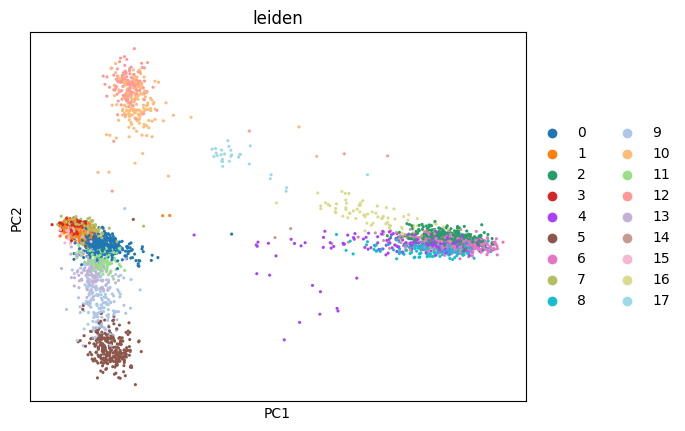

In [70]:
sc.pl.pca(
    adata_protein,
    color=['leiden'],
    size=20
)

Save the clustering results

In [71]:
df = pd.DataFrame(adata_protein.obs['leiden'])
labels = df.rename(columns={'leiden': 'cluster'})
labels.index.name = 'cell'
labels['cluster'] = labels['cluster'].astype(int) + 1
labels.to_csv(f'{protein_path}/clustering_labels.csv', index=True)
num_clusters = len(labels['cluster'].unique())

## Differential expression on clusters tuned according to protein surface

In [72]:
sc.tl.rank_genes_groups(adata_protein, 'leiden', method='wilcoxon') # default='t-test', wilcoxon suggested in the tutorial

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Save markers

In [73]:
number_of_markers = 500
df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])
for i in range(num_clusters):
    indices = np.argsort(adata_protein.uns['rank_genes_groups']['pvals_adj'][str(i)])
    genes = adata_protein.uns['rank_genes_groups']['names'][str(i)][indices][:number_of_markers]
    ranks = rankdata(adata_protein.uns['rank_genes_groups']['pvals_adj'][str(i)][indices][:number_of_markers], method="ordinal")
    df_to_add = pd.DataFrame(
        np.column_stack((genes, [i+1 for _ in range(number_of_markers)], ranks)),
        columns=['gene', 'cluster', 'rank']
    )
    df = pd.concat([df, df_to_add], ignore_index=True)

df['cluster'] = df['cluster'].astype(int)
df['rank'] = df['rank'].astype(int)
df.to_csv(f'{protein_path}/markers.csv', index=False)